In [1]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
color_sns = sns.cubehelix_palette(8, start=.5, rot=-.75)

# Rocksdb

<ipython-input-2-5ac4e4900df5>:28: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(10)


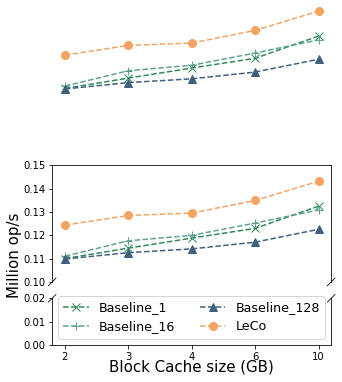

In [2]:
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from brokenaxes import brokenaxes
Baseline = [0.110038,0.114483,0.118789,0.122976,0.132508]
Baseline_16=[0.111025,0.117650,0.119981,0.125244,0.130878]
Baseline_128 = [0.109812,0.112544,0.114175,0.117051,0.122561]
Leco=[0.124348,0.128505,0.129521,0.134952,0.143202]
FOR=[0.109088,0.113897,0.117474,0.124294,0.132217]
# EF = [0.094909, 0.098598, 0.101269, 0.104480, 0.110961]
label = ['Baseline_1','Baseline_16','Baseline_128','LeCo']
dataset = [Baseline, Baseline_16,Baseline_128,Leco]
mark_style = ['x','+','^','o']
# colors = ['sandybrown','lightseagreen','seagreen', 'slategray']
colors =  ['seagreen',color_sns[3],color_sns[5],'sandybrown']
plt.figure(figsize=(5, 3.3))
bax = brokenaxes( ylims=[(0, 0.02), (0.1, 0.15)], despine=False)
for i in range(len(dataset)):
    bax.plot(dataset[i],ls='--',marker=mark_style[i],label = label[i], c = colors[i],ms=8,clip_on=False)

bax.set_ylabel('Million op/s',fontsize=15)
bax.set_xlabel('Block Cache size (GB)',fontsize=15)
# plt.title('Rocksdb index block',fontsize=23)
# plt.ylim([0,0.16])
bax.set_xticks([0,1,2,3,4],['2','3','4','6','10'], fontsize=10)
# bax.set_yticks(fontsize=10)
for i in range(2):
    for tick in bax.axs[i].get_yaxis().get_major_ticks():
        tick.label.set_fontsize(10)
bax.legend(fontsize=12.6, loc=4, ncol = 2)
# plt.tight_layout()
# plt.subplots_adjust(left=0.12, right=0.97, bottom=0.2, top=0.95)
plt.savefig("Rocksdb.pdf", bbox_inches='tight', pad_inches=0.05, transparent=True)
# plt.savefig('Rocksdb.pdf',dpi=500, transparent=True)
plt.show()


# Parquet

In [10]:
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
category_colors = [color_sns[5],color_sns[3],color_sns[1],'sandybrown','peachpuff']
def plot_zstd_bar(wo_zstd, cpu_wo_zstd, w_zstd, cpu_w_zstd, titlename):
    methods = ['Default','FOR','LeCo']
    X = np.arange(3)+1
    fig, ax = plt.subplots(figsize=(5, 3.3))
    bar_width = 0.4
    plt.bar(X-0.2, cpu_wo_zstd,bottom=wo_zstd - cpu_wo_zstd, label = "CPU_w/o_zstd",width = bar_width, color = color_sns[3], hatch='\\\\',ec=color_sns[4])
    plt.bar(X-0.2, wo_zstd - cpu_wo_zstd, label = "IO_w/o_zstd",width = bar_width, color = color_sns[1],ec=color_sns[2])
    plt.bar(X+0.2, cpu_w_zstd,bottom=w_zstd - cpu_w_zstd, label = "CPU_w/_zstd",width = bar_width, color = category_colors[-2], hatch='//',ec='chocolate')
    plt.bar(X+0.2, w_zstd - cpu_w_zstd, label = "IO_w/_zstd" ,width = bar_width,  color = category_colors[-1], ec=category_colors[-2])
    plt.legend(fontsize=14,ncols = 1,borderaxespad = 0.5)
    plt.xticks(X, methods, fontsize=17)
    plt.yticks(fontsize=13)
    plt.ylabel("Query Time(s)", fontsize = 15)
    ymajorLocator = MultipleLocator(0.5)
    plt.gca().yaxis.set_major_locator(ymajorLocator)
#     plt.title(titlename, fontsize = 18)
    plt.tight_layout()
    plt.savefig('parquet_bitmap_{}.pdf'.format(titlename),dpi=500, transparent=True)
    plt.show()

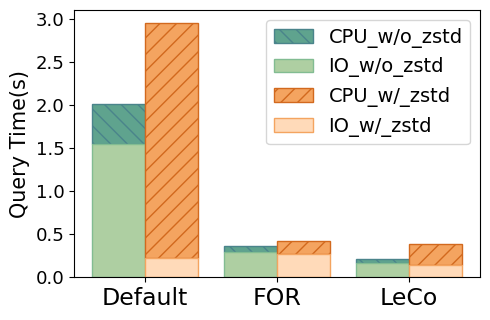

In [11]:
datasets = ['normal_200M_uint32.txt','books_200M_uint32.txt','poisson_timestamps_EVENT_50000_SENSOR_2000_randomdie_OUTER_1000s_INNER_2ms_200M.csv','ml_timestamp_200M.csv']
# datasets = ['normal_200M_uint32.txt']
figname = ['normal','booksale','poisson','ml']
withylabel = [1,0,1,0]
withxlabel = [0,0,1,1]
dataset = 'ml_timestamp_200M.csv'
file_zstd = '/root/parquet_bitmap_zstd.csv'
wo_zstd = []
w_zstd = []
cpu_wo_zstd = []
cpu_w_zstd = []
for method in ['DICT','FOR','LECO']:
    wo_zstd.append(get_data(method, dataset, 'query_time')[2])
    w_zstd.append(get_data(method, dataset, 'query_time',file_zstd)[2])
    cpu_wo_zstd.append(get_data(method, dataset, 'query_time_preload')[2])
    cpu_w_zstd.append(get_data(method, dataset, 'query_time_preload',file_zstd)[2])

plot_zstd_bar(np.array(wo_zstd), np.array(cpu_wo_zstd), np.array(w_zstd), np.array(cpu_w_zstd),'ml_wo_zstd')


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
name = 'zstd_result_new.csv'
encoding_map = {'DICT': 8, 'FOR': 10, 'LECO': 11}
enc_to_label = {'LECO': 'LeCo', 'FOR': 'FOR', 'DICT': 'Default', 'PLAIN': 'Plain'}
encoding_names = []
for enc in encoding_map.keys():
        encoding_names.append(enc_to_label[enc])
df = pd.read_csv(name) 
df = df[df['encoding'] != 'PLAIN']
colors = ['darkseagreen','seagreen','sandybrown']
# print(df)
barWidth = 0.1
cnt = 0
zstd_cr_total = []
for ds in dataset_dict:
    no_zstd_res = df.loc[(df['file'] == ds) & (df['compression'].isnull()), 'size']
    #divide all values in no_zstd_res by 1024
    no_zstd_res = no_zstd_res / 1024 / 1024
    zstd_res = df.loc[(df['file'] == ds) & (df['compression'] == '.zstd'), 'size']
    zstd_res = zstd_res / 1024 / 1024
    no_zstd_enc = df.loc[(df['file'] == ds) & (df['compression'].isnull()), 'encoding']
    zstd_enc = df.loc[(df['file'] == ds) & (df['compression'] == '.zstd'), 'encoding']
    zstd_cr = no_zstd_res.to_numpy().flatten() / zstd_res.to_numpy().flatten()
    zstd_cr_total.extend(zstd_cr)
    # print(no_zstd_res)
    # print(zstd_res)
    # print(no_zstd_enc)
    # print(zstd_enc)

In [100]:
def create_multi_bars(labels, datas, name, zstd_res_total, tick_step=1.5, group_gap=0.15, bar_gap=0):
    codec = ['Default', 'Default-zstd', 'FOR', 'FOR-zstd', 'LeCo', 'LeCo-zstd']
#     category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, len(data)))
    category_colors = ['steelblue','lightsteelblue','seagreen','darkseagreen','sandybrown','peachpuff']
    category_colors = [color_sns[6],color_sns[5],color_sns[3],color_sns[1],'sandybrown','peachpuff']
    ticks = np.arange(len(labels)) * tick_step
    group_num = len(datas)
    group_width = tick_step - group_gap
    bar_span = group_width / group_num
    bar_width = bar_span - bar_gap
    baseline_x = ticks - (group_width - bar_span) / 2
    plt.figure(figsize=(5, 3))

    plt.ylabel('File Size (GB)',fontsize=16)
    for index, y in enumerate(datas):
        plt.bar(baseline_x + index*bar_span, y, bar_width, label =codec[index],color = category_colors[index] )
    gap = baseline_x[1] - baseline_x[0]
    for i in range(len(labels)):
        zstd_cr_tmp = zstd_cr_total[(0 + i*3): (3 + i*3)]
        zstd_res_tmp = zstd_res_total[(0 + i*3): (3 + i*3)]
        speedup_xspace, speedup_yspace = -0.4 + i * gap, 20/1024
        for x, y, s in zip([bar_width*r*2 for r in range(len(zstd_res_tmp))], 
                zstd_res_tmp, zstd_cr_tmp):
            plt.text(x + speedup_xspace-0.1, y + speedup_yspace,
                "%.1fx"%(s), fontsize=10.5)
#     plt.legend(fontsize=21)
    plt.legend(fontsize=10,ncol=3,bbox_to_anchor=(0,1.02,1,0.2),borderaxespad = 0.)
    # plt.ylim([0,4])
    ax = plt.gca()
    ymajorLocator = MultipleLocator(0.5)
    ax.yaxis.set_major_locator(ymajorLocator)
    # ymajorLocator = MultipleLocator(1.0)
    # ax.yaxis.set_major_locator(ymajorLocator)
    # ymajorFormatter = FormatStrFormatter('%1.1f')
    # ax.yaxis.set_major_formatter(ymajorFormatter)
#     ax.yaxis.tick_right()
    plt.xlim([min(baseline_x)-0.2, max(baseline_x)+1.5])
    plt.yticks(fontsize=10)
    plt.xticks(ticks, labels, fontsize=15)
    plt.tight_layout()
    plt.savefig(f'zstd_{name}_new.pdf',dpi=500, transparent=True)
    plt.show()

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
name = 'zstd_result_new.csv'
encoding_map = {'DICT': 8, 'FOR': 10, 'LECO': 11}
enc_to_label = {'LECO': 'LeCo', 'FOR': 'FOR', 'DICT': 'Default', 'PLAIN': 'Plain'}
encoding_names = []
for enc in encoding_map.keys():
        encoding_names.append(enc_to_label[enc])
df = pd.read_csv(name) 
df = df[df['encoding'] != 'PLAIN']
colors = ['darkseagreen','seagreen','sandybrown']
# print(df)
barWidth = 0.1
cnt = 0
zstd_cr_total = []
for ds in dataset_dict:
    no_zstd_res = df.loc[(df['file'] == ds) & (df['compression'].isnull()), 'size']
    #divide all values in no_zstd_res by 1024
    no_zstd_res = no_zstd_res / 1024 / 1024
    zstd_res = df.loc[(df['file'] == ds) & (df['compression'] == '.zstd'), 'size']
    zstd_res = zstd_res / 1024 / 1024
    no_zstd_enc = df.loc[(df['file'] == ds) & (df['compression'].isnull()), 'encoding']
    zstd_enc = df.loc[(df['file'] == ds) & (df['compression'] == '.zstd'), 'encoding']
    zstd_cr = no_zstd_res.to_numpy().flatten() / zstd_res.to_numpy().flatten()
    zstd_cr_total.extend(zstd_cr)
    # print(no_zstd_res)
    # print(zstd_res)
    # print(no_zstd_enc)
    # print(zstd_enc)

In [40]:
def create_multi_bars(labels, datas, name, zstd_res_total, tick_step=1.5, group_gap=0.15, bar_gap=0):
    codec = ['Default', 'Default-zstd', 'FOR', 'FOR-zstd', 'LeCo', 'LeCo-zstd']
#     category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, len(data)))
    category_colors = ['steelblue','lightsteelblue','seagreen','darkseagreen','sandybrown','peachpuff']
    category_colors = [color_sns[6],color_sns[5],color_sns[3],color_sns[1],'sandybrown','peachpuff']
    ticks = np.arange(len(labels)) * tick_step
    group_num = len(datas)
    group_width = tick_step - group_gap
    bar_span = group_width / group_num
    bar_width = bar_span - bar_gap
    baseline_x = ticks - (group_width - bar_span) / 2
    plt.figure(figsize=(16, 4.7))

    plt.ylabel('File Size (GB)',fontsize=37)
    for index, y in enumerate(datas):
        plt.bar(baseline_x + index*bar_span, y, bar_width, label =codec[index],color = category_colors[index] )
    gap = baseline_x[1] - baseline_x[0]
    for i in range(len(labels)):
        zstd_cr_tmp = zstd_cr_total[(0 + i*3): (3 + i*3)]
        zstd_res_tmp = zstd_res_total[(0 + i*3): (3 + i*3)]
        speedup_xspace, speedup_yspace = -0.4 + i * gap, 20/1024
        for x, y, s in zip([bar_width*r*2 for r in range(len(zstd_res_tmp))], 
                zstd_res_tmp, zstd_cr_tmp):
            plt.text(x + speedup_xspace-0.07, y + speedup_yspace,
                "%.1fx"%(s), fontsize=23)
    plt.legend(fontsize=21)
#     plt.legend(fontsize=21,ncol=3,bbox_to_anchor=(0,1.02,1,0.2),borderaxespad = 0.)
    # plt.ylim([0,4])
    ax = plt.gca()
    ymajorLocator = MultipleLocator(0.5)
    ax.yaxis.set_major_locator(ymajorLocator)
    # ymajorLocator = MultipleLocator(1.0)
    # ax.yaxis.set_major_locator(ymajorLocator)
    # ymajorFormatter = FormatStrFormatter('%1.1f')
    # ax.yaxis.set_major_formatter(ymajorFormatter)
#     ax.yaxis.tick_right()
    plt.xlim([min(baseline_x)-0.2, max(baseline_x)+1.5])
    plt.yticks(fontsize=22)
    plt.xticks(ticks, labels, fontsize=30)
    plt.tight_layout()
    plt.savefig(f'zstd_{name}_new.pdf',dpi=500, transparent=True)
    plt.show()

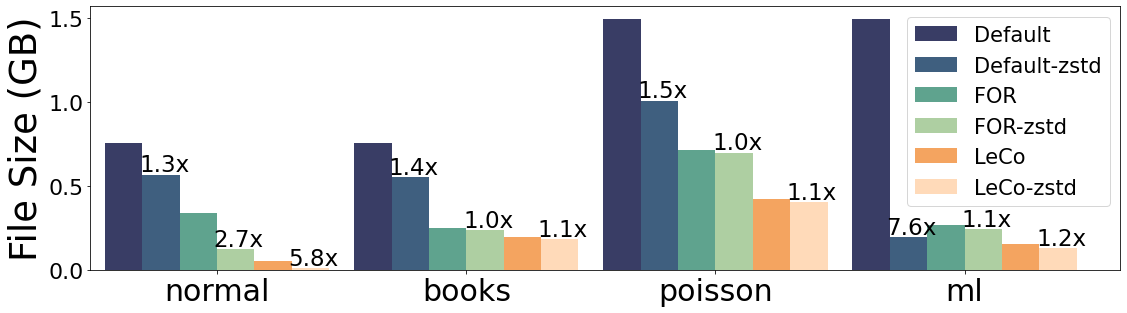

In [41]:
labels = ['normal', 'books', 'poisson', 'ml']
datas = [[], [], [], [], [], []]
zstd_res_total = []
for ds in dataset_dict:
    no_zstd_res = df.loc[(df['file'] == ds) & (df['compression'].isnull()), 'size']
    #divide all values in no_zstd_res by 1024
    no_zstd_res = list(no_zstd_res / 1024 / 1024 / 1024)
    zstd_res = df.loc[(df['file'] == ds) & (df['compression'] == '.zstd'), 'size']
    zstd_res = list(zstd_res / 1024 / 1024 / 1024)
    zstd_res_total.extend(zstd_res)
    data = []
    for i in range(len(no_zstd_res)):
        datas[i*2].append(no_zstd_res[i])
        datas[i*2 + 1].append(zstd_res[i])
create_multi_bars(labels, datas, 'total', zstd_res_total)